# Design of Experiments for the JC Cracker

In this notebook we set up an initial experimental design for the JC Cracker using Latin Hypercube Sampling (LHS) with 40 experiments. The purpose is to capture a highly nonlinear response surface of our system with 6 key variables. Later, we use Bayesian optimization to refine the experimental conditions.

### Experimental Variables and Their Ranges:
1. **Soaking Time (Hours):** 5 to 50  
2. **Air-Drying Time (Minutes):** 10 to 60  
3. **Plate Contact Frequency (Hz):** 30 to 60  
4. **Throughput Rate (nuts/s):** 12 to 38  
5. **Crush Amount (inches):** 0.025 to 0.125  
6. **Entry-Exit Height Difference (inches):** -0.09375 to 0.1875  

With 40 experiments we can better capture the complex nonlinear interactions you expect. The steps in this notebook are:

1. **Define the Design Space:** Set up variable ranges based on our design of experiments.
2. **Generate Initial Design (LHS):** Create 40 initial experimental points that are uniformly distributed across the design space.
3. **Define a Dummy Objective Function:** For demonstration purposes, we assume the optimum is at the midpoint of each variable range. In your actual application, this function should return the measured outcome (e.g., yield or quality).
4. **Run Bayesian Optimization:** Using `gp_minimize` from scikit-optimize, we refine the search for the best experimental conditions.
5. **Plot Convergence:** Visualize the progress of the optimization.

Feel free to adjust the variable ranges, the number of experiments, or the objective function according to your actual experimental setup.
"""

Initial Design (LHS, integer for first 4, 2 decimals for last 2):


,Soaking Time (Hours),Air-Drying Time (Minutes),Plate Contact Frequency (Hz),Throughput Rate (nuts/s),Crush Amount (inches),Entry-Exit Height Diff (inches)
0,36,40,59,14,0.08,-0.04
1,42,36,48,23,0.03,-0.04
2,20,37,37,34,0.09,0.18
3,20,34,35,30,0.12,0.16
4,49,10,45,26,0.05,0.11
5,14,31,49,21,0.09,0.13
6,18,24,42,32,0.06,0.02
7,41,25,46,20,0.10,0.04
8,28,49,38,14,0.05,0.12
9,48,54,50,36,0.12,0.04



Best found parameters from Bayesian Optimization:
Soaking Time (Hours): 33.0
Air-Drying Time (Minutes): 30.0
Plate Contact Frequency (Hz): 44.0
Throughput Rate (nuts/s): 20.0
Crush Amount (inches): 0.12
Entry-Exit Height Diff (inches): 0.08
Objective function value: 81.2531


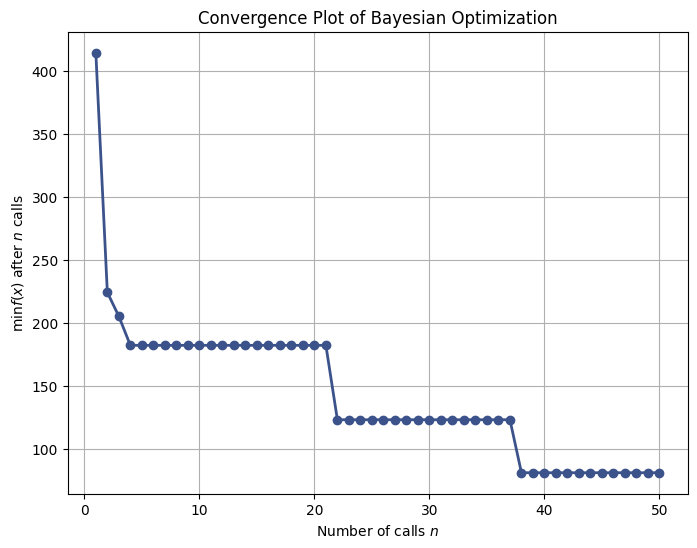

In [2]:
# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import qmc
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.plots import plot_convergence

# # This code snippet uses a combined LHS + Bayesian optimization approach
# # #LHS -> Latin Hypercube Sampling
# # #BayesianOptimization -> gp_minimize
# # #IntegerVariables -> first four variables as integers
# # #RealVariables -> last two remain continuous but displayed with .2f
# # #ObjectiveFunction -> user-specified, here dummy sum of squares
# # #EI -> Expected Improvement acquisition
# # #ConvergencePlot -> shows objective convergence

# %% [markdown]
"""
## Step 1: Define the Experimental Design Space

- First 4 variables: Integers
- Last 2 variables: Continuous, displayed with 2 decimals
"""

# Define variable bounds (min, max) for each experimental variable
variable_bounds = [(5, 50), (10, 60), (30, 60), (12, 38), (0.025, 0.125), (-0.09375, 0.1875)]  # Soaking Time (Hours) [Integer]  # Air-Drying Time (Minutes) [Integer]  # Plate Contact Frequency (Hz) [Integer]  # Throughput Rate (nuts/s) [Integer]  # Crush Amount (inches) [Real, 2 decimals]  # Entry-Exit Height Diff (inches) [Real, 2 decimals]

variable_names = ["Soaking Time (Hours)", "Air-Drying Time (Minutes)", "Plate Contact Frequency (Hz)", "Throughput Rate (nuts/s)", "Crush Amount (inches)", "Entry-Exit Height Diff (inches)"]

# %% [markdown]
"""
## Step 2: Generate the Initial Design Using Latin Hypercube Sampling (LHS)

We generate 40 points, then round the first 4 as integers and the last 2 to 2 decimal places for clarity.
"""

# Number of initial LHS points
n_initial = 40

# Instantiate LHS sampler
sampler = qmc.LatinHypercube(d=len(variable_bounds))
sample = sampler.random(n_initial)  # Generate samples in unit hypercube

l_bounds = [b[0] for b in variable_bounds]
u_bounds = [b[1] for b in variable_bounds]

# Scale the unit hypercube samples
scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

# Convert to DataFrame
initial_design = pd.DataFrame(scaled_sample, columns=variable_names)

# Round the first 4 to integers
int_cols = ["Soaking Time (Hours)", "Air-Drying Time (Minutes)", "Plate Contact Frequency (Hz)", "Throughput Rate (nuts/s)"]
for col in int_cols:
    initial_design[col] = initial_design[col].round().astype(int)

# Round last 2 to 2 decimals (for display/initial design)
real_cols = ["Crush Amount (inches)", "Entry-Exit Height Diff (inches)"]
for col in real_cols:
    initial_design[col] = initial_design[col].round(2)

print("Initial Design (LHS, integer for first 4, 2 decimals for last 2):")
display(initial_design)

# %% [markdown]
"""
## Step 3: Define a Dummy Objective Function

Replace with your actual measurement in practice.
"""

# Calculate midpoints as target
target = np.array([(b[0] + b[1]) / 2 for b in variable_bounds])


def objective(x):
    """
    Dummy objective function:
    sum of squared deviations from the midpoint of each variable range.
    """
    x = np.array(x)
    return np.sum((x - target) ** 2)


# %% [markdown]
"""
## Step 4: Run Bayesian Optimization

Define integer or real search spaces accordingly.
"""

search_space = [Integer(5, 50, name=variable_names[0]), Integer(10, 60, name=variable_names[1]), Integer(30, 60, name=variable_names[2]), Integer(12, 38, name=variable_names[3]), Real(0.025, 0.125, name=variable_names[4]), Real(-0.09375, 0.1875, name=variable_names[5])]  # Soaking Time  # Air-Drying Time  # Plate Frequency  # Throughput  # Crush Amount  # Entry-Exit Diff

# Use the integer/2-decimal initial design as x0
# (Even though we display 2 decimals for the last 2, they remain Real in the optimization.)
result = gp_minimize(func=objective, dimensions=search_space, acq_func="EI", n_calls=50, x0=initial_design.values.tolist(), random_state=42)  # Expected Improvement

print("\nBest found parameters from Bayesian Optimization:")
for name, val in zip(variable_names, result.x):
    # Print integers as integer, reals to 2 decimals
    if name in int_cols:
        print(f"{name}: {val}")
    else:
        print(f"{name}: {val:.2f}")
print(f"Objective function value: {result.fun:.4f}")

# %% [markdown]
"""
## Step 5: Plot the Convergence of the Optimization Process
"""

plt.figure(figsize=(8, 6))
plot_convergence(result)
plt.title("Convergence Plot of Bayesian Optimization")
plt.show()